In [1]:
# Add the parent directory to sys.path
import sys, os
from pathlib import Path

current_directory = os.getcwd()
parent_directory = Path(current_directory).parent.parent
sys.path.insert(0, str(parent_directory))
sys.path

['c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv',
 '',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\Pythonwin']

In [3]:
# Import the utils moudle
from scripts import utils

In [4]:
# Load the credentialsand connect to database
CREDENTIALS  = utils.load_environment_variables(parent_directory=parent_directory)
connection = utils.connect_to_database({"dbname": CREDENTIALS['DB_NAME'],
                                 "user": CREDENTIALS['USER'],
                                 "host": CREDENTIALS['host'],
                                 "port": CREDENTIALS['port']})

INFO:scripts.utils:Trying to load environment variables from c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis/.env
INFO:scripts.utils:Credentials loaded successfully
INFO:scripts.utils:Attempting to connect to the database
INFO:scripts.utils:Connection successful


In [5]:
# Load the db files into pandas dataframe and close the connection
table_name = 'xdr_data'
df = utils.load_data_from_db(conn=connection,
                       table_name=table_name)
utils.close_database_connection(conn=connection)

INFO:root:Executing query: SELECT * FROM xdr_data
c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis\scripts\utils.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:scripts.utils:Data loaded into DataFrame successfully
INFO:root:Database connection closed successfully


### Aggregate relevant metrics for each user

In [6]:
# Aggregate session duration per customer
session_duration = df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index()
session_duration.columns = ['MSISDN/Number', 'Session Dur. (ms)']
session_duration.head()

,MSISDN/Number,Session Dur. (ms)
0,3.360100e+10,116720.0
1,3.360100e+10,181230.0
2,3.360100e+10,134969.0
3,3.360101e+10,49878.0
4,3.360101e+10,37104.0


In [7]:
# Calculate the session frequency per customer
session_frequency = df.groupby('MSISDN/Number')['Bearer Id'].count().reset_index()
session_frequency.columns = ['MSISDN/Number', 'Session Frequency']
session_frequency.head()

,MSISDN/Number,Session Frequency
0,3.360100e+10,1
1,3.360100e+10,1
2,3.360100e+10,1
3,3.360101e+10,1
4,3.360101e+10,2


In [8]:
# Calculate total traffic per user
df['Total Data (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
total_traffic = df.groupby('MSISDN/Number')['Total Data (Bytes)'].sum().reset_index()
total_traffic.head()

,MSISDN/Number,Total Data (Bytes)
0,3.360100e+10,8.786906e+08
1,3.360100e+10,1.568596e+08
2,3.360100e+10,5.959665e+08
3,3.360101e+10,4.223207e+08
4,3.360101e+10,1.457411e+09


In [9]:
# Merge all the data frames on MSISDN
import pandas as pd
relevant_df = pd.merge(session_duration, session_frequency, on='MSISDN/Number')
relevant_df = pd.merge(relevant_df, total_traffic, on='MSISDN/Number')
relevant_df.head()

,MSISDN/Number,Session Dur. (ms),Session Frequency,Total Data (Bytes)
0,3.360100e+10,116720.0,1,8.786906e+08
1,3.360100e+10,181230.0,1,1.568596e+08
2,3.360100e+10,134969.0,1,5.959665e+08
3,3.360101e+10,49878.0,1,4.223207e+08
4,3.360101e+10,37104.0,2,1.457411e+09


### K-Engagement Analysis

In [11]:
# Import the engagement utils module
from scripts import enagagement_utils

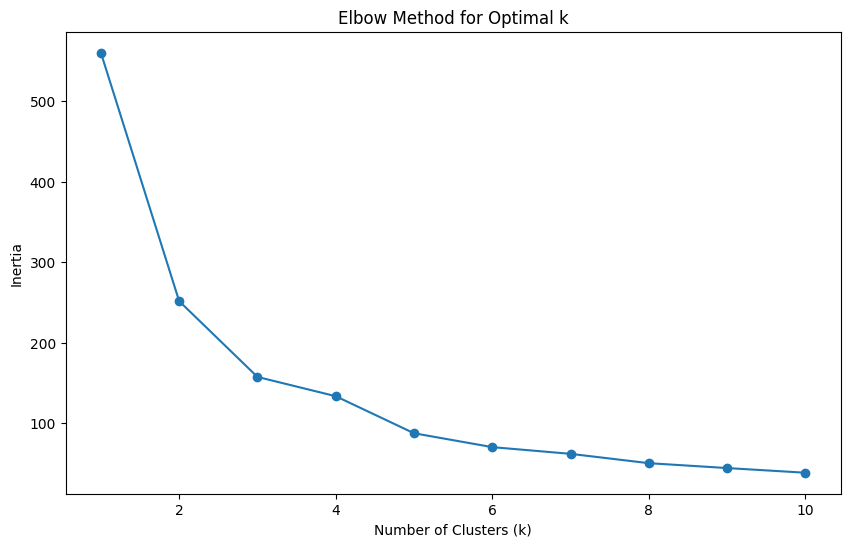

INFO:root:Elbow method executed successfully.


In [12]:
# Normalize and cluster data
normalized_data = enagagement_utils.normalize_data(df=relevant_df)
enagagement_utils.elbow_method(normalized_data=normalized_data)

- The optimized value of k based on the above output would be 3.
 - After this point, the inertia continues to decrease but at a much more gradual rate. Therefore, using 3 clusters seems to be the optimal choice for segmenting the users based on engagement metrics.
 - After k = 3, the rate of decrease flattens, meaning additional clusters do not significantly reduce inertia. Hence, adding more clusters beyond 3 would provide diminishing returns in terms of clustering quality.